Import libraries

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from netCDF4 import Dataset
import csv
from datetime import date, timedelta, datetime
import os.path
import re
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors
import cartopy.feature
import xarray as xr

Read in CVAO data

In [3]:
# Specify the directory containing the files
directory_path = '/scratch/ajp255/homes/mrr32/home/data/PartIII_23/CVAO/O3'

# List all files in the directory
file_names = os.listdir(directory_path)

# Create a Pandas DataFrame from the file names
df = pd.DataFrame({'file_name': file_names})

# Extract information from file names
df['base_date'] = df['file_name'].str.extract(r'(\d{8})')

# Convert 'base_date' to datetime format
df['base_date'] = pd.to_datetime(df['base_date'], format='%Y%m%d')
df = df.sort_values(by='base_date', ascending=True)

def process_netcdf_file(file_info, directory_path):
    name, base_date = file_info
    file_path = os.path.join(directory_path, name)

    with Dataset(file_path, 'r') as nc_file:
        data = {}  # Create an empty dictionary to store variable data

        # Define the variables you want and add them to the dictionary
        variable_list = ['time', 'latitude', 'longitude', 'o3_concentration_in_air', 'qc_flag']

        for variable in variable_list:
            if variable in nc_file.variables:
                if variable == 'o3_concentration_in_air':
                    data['obs_ozone'] = nc_file.variables[variable][:]
                else:
                    data[variable] = nc_file.variables[variable][:]

        # Repeat latitude and longitude values for every row
        if 'latitude' in data:
            data['latitude'] = np.repeat(data['latitude'], len(data['time']))

        # Set constant longitude for every row (from observatory coordinates)
        constant_longitude = -24.8672  
        data['longitude'] = np.full(len(data['time']), constant_longitude)
        
        # Create a new column 'altitude' and assign a value of 45 for every row
        #data['altitude'] = 300
        
        # Convert time to days
        sec_per_day = 24 * 60 * 60
        data['time'] = data['time'] / sec_per_day

    # Create a DataFrame for the current file
    return pd.DataFrame(data)

# Create an empty list to store individual DataFrames
dataframes = []

for name, base_date in zip(df['file_name'], df['base_date']):
    result = process_netcdf_file((name, base_date), directory_path)
    if result is not None:
        dataframes.append(result)

# Concatenate all individual DataFrames into a single DataFrame
obs_cvao = pd.concat(dataframes, ignore_index=True)

model_base_date = datetime(1900, 1, 1)
model_start_date = datetime(1986, 1, 1)
obs_base_date = datetime(1970, 1, 1)
start_days_difference = (model_start_date - model_base_date).days
last_model_date = 44710.957639
obs_cvao['time'] = obs_cvao['time'] + (obs_base_date - model_base_date).days
obs_cvao = obs_cvao[(obs_cvao['time'] >= start_days_difference) & (obs_cvao['time'] <= last_model_date)]
obs_cvao = obs_cvao.sort_values(by='time', ascending=True)

obs_cvao

# Drop rows where either "obs_ozone" is NaN
obs_cvao = obs_cvao.dropna(subset=['obs_ozone'])
obs_cvao['time'] = pd.to_datetime(obs_cvao['time'], origin='1900-01-01', unit='D')
hourly_cvao_data = obs_cvao.groupby(pd.Grouper(key='time', freq='h')).mean()

# Display the mergeing DataFrame
hourly_cvao_data

,latitude,longitude,obs_ozone,qc_flag
time,,,,
2006-10-02 15:00:00,16.8636,-24.8672,17.338793,1.0
2006-10-02 16:00:00,16.8636,-24.8672,17.931017,1.0
2006-10-02 17:00:00,16.8636,-24.8672,18.475333,1.0
2006-10-02 18:00:00,16.8636,-24.8672,19.027541,1.0
2006-10-02 19:00:00,16.8636,-24.8672,21.211186,1.0
...,...,...,...,...
2022-05-31 18:00:00,16.8636,-24.8672,21.745000,1.0
2022-05-31 19:00:00,16.8636,-24.8672,21.667373,1.0
2022-05-31 20:00:00,16.8636,-24.8672,21.949831,1.0


Initialise directory path for ERA5 data

In [4]:
# Directory path
directory_path = '/home/ajp255/nethome/Data/ERA5_data/'

# Get all file names in the directory
file_names = os.listdir(directory_path)

Create dataframe with all physical variables from 2006-2018

In [5]:
# Filter files with "merge_2006_2018" in their names
file_paths = [os.path.join(directory_path, f) for f in file_names if "2006_2018" in f]

# Function to convert xarray Dataset to pandas DataFrame
def xr_to_df(ds):
    # Convert dataset to DataFrame
    df = ds.to_dataframe().reset_index()
    return df

# Initialize empty DataFrames
dfs = []

# Iterate over file paths
for file_path in file_paths:
    # Open NetCDF file using xarray
    ds = xr.open_dataset(file_path)
    
    # Convert dataset to DataFrame and append to list
    df = xr_to_df(ds)
    dfs.append(df)

# Merge DataFrames based on latitude, longitude, and time
merge_2006_2018 = pd.concat(dfs).groupby(['latitude', 'longitude', 'time']).first().reset_index()

# Filter files with "2019_2022" in their names
file_paths = [os.path.join(directory_path, f) for f in file_names if "2019_2022" in f]

# Function to convert xarray Dataset to pandas DataFrame
def xr_to_df(ds):
    # Convert dataset to DataFrame
    df = ds.to_dataframe().reset_index()
    return df

# Initialize empty DataFrames
dfs = []

# Iterate over file paths
for file_path in file_paths:
    # Open NetCDF file using xarray
    ds = xr.open_dataset(file_path)
    
    # Convert dataset to DataFrame and append to list
    df = xr_to_df(ds)
    dfs.append(df)

# Merge DataFrames based on latitude, longitude, and time
merge_2019_2022 = pd.concat(dfs).groupby(['latitude', 'longitude', 'time']).first().reset_index()

# Concatenate the DataFrames merge_2006_2018 and merge_2019_2022
physical_vars = pd.concat([merge_2006_2018, merge_2019_2022], ignore_index=True)

# Calculate wind speed
physical_vars['wind_speed'] = np.sqrt(physical_vars['u10']**2 + physical_vars['v10']**2)

# Calculate wind direction
physical_vars['wind_direction'] = np.arctan2(physical_vars['u10'], physical_vars['v10']) * (180 / np.pi)

# Display the concatenated DataFrame
physical_vars

,latitude,longitude,time,tp,u10,sp,blh,v10,ssrc,t2m,ssr,o3,wind_speed,wind_direction
0,16.0,-26.0,2006-01-01 00:00:00,9.313226e-10,-7.352587,101535.476562,885.139893,-3.786325,-0.125,296.678314,-0.125,NaN,8.270235,-117.246891
1,16.0,-26.0,2006-01-01 01:00:00,9.313226e-10,-7.007782,101492.710938,869.514404,-3.684158,-0.125,296.608215,-0.125,NaN,7.917199,-117.731971
2,16.0,-26.0,2006-01-01 02:00:00,9.313226e-10,-6.770461,101459.648438,873.711487,-3.528882,-0.125,296.585327,-0.125,NaN,7.634929,-117.529305
3,16.0,-26.0,2006-01-01 03:00:00,9.313226e-10,-6.678026,101441.890625,889.620544,-3.350652,-0.125,296.547638,-0.125,NaN,7.471472,-116.644878
4,16.0,-26.0,2006-01-01 04:00:00,9.313226e-10,-6.636322,101398.328125,928.925293,-3.352452,-0.125,296.512329,-0.125,NaN,7.435032,-116.801398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12070291,18.0,-24.0,2022-12-31 19:00:00,0.000000e+00,-3.508660,101565.437500,1003.828796,-1.627723,276442.250,295.827362,255844.500,NaN,3.867838,-114.887334
12070292,18.0,-24.0,2022-12-31 20:00:00,0.000000e+00,-3.662231,101661.882812,1017.206848,-1.561801,2225.250,295.813934,1947.000,NaN,3.981351,-113.096383
12070293,18.0,-24.0,2022-12-31 21:00:00,0.000000e+00,-4.024518,101694.617188,1042.543213,-1.496608,-0.125,295.809052,-0.125,NaN,4.293784,-110.398779
12070294,18.0,-24.0,2022-12-31 22:00:00,0.000000e+00,-3.875115,101787.468750,1103.727417,-1.218352,-0.125,295.851288,-0.125,NaN,4.062129,-107.453356


Merge observation CVAO data and physical variables

In [6]:
merge = pd.merge(hourly_cvao_data, physical_vars, on='time', how='inner')
total_merge = merge.drop_duplicates(subset=['time'])

Interannual observed ozone vs temperature

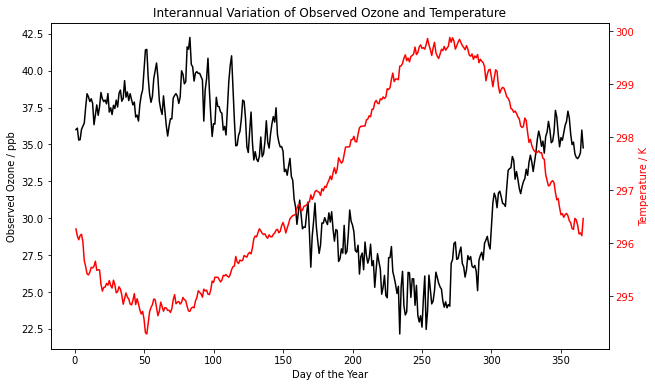

In [7]:
# Convert the 'time' column to datetime format by explicitly creating a copy
total_merge = total_merge.copy()
total_merge['time'] = pd.to_datetime(total_merge['time'])

# Extract day of the year from the datetime and create a new column
total_merge['day_of_year'] = total_merge['time'].dt.dayofyear

# Group by day of the year and calculate the mean for each day
daily_mean = total_merge.groupby('day_of_year').mean()

# Plotting the interannual variation of 'obs_ozone' and 't2m'
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'obs_ozone' on the left y-axis
ax1.plot(daily_mean.index, daily_mean['obs_ozone'], label='Observed Ozone', color='k')
ax1.set_xlabel('Day of the Year')
ax1.set_ylabel('Observed Ozone / ppb', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Create a secondary y-axis for 't2m' on the right side
ax2 = ax1.twinx()

# Plot 't2m' on the secondary y-axis
ax2.plot(daily_mean.index, daily_mean['t2m'], label='Temperature', color='r')
ax2.set_ylabel('Temperature / K', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
plt.title('Interannual Variation of Observed Ozone and Temperature')
plt.show()

Interannual observed ozone vs boundary layer height

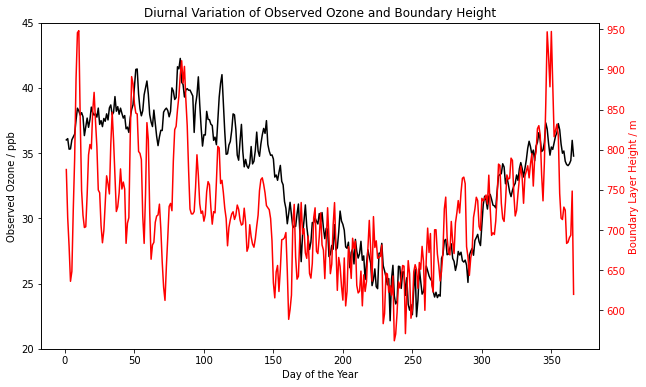

In [8]:
# Plotting the diurnal variation of 'obs_ozone' and 'blh'
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'obs_ozone' on the left y-axis
ax1.plot(daily_mean.index, daily_mean['obs_ozone'], label='Observed Ozone', color='k')
ax1.set_xlabel('Day of the Year')
ax1.set_ylabel('Observed Ozone / ppb', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Set the y-axis limit for 'obs_ozone' to cover the range of data
ax1.set_ylim(20, top=45)

# Create a secondary y-axis for 'blh' on the right side
ax2 = ax1.twinx()

# Plot 'blh' on the secondary y-axis
ax2.plot(daily_mean.index, daily_mean['blh'], label='Boundary Height', color='r')
ax2.set_ylabel('Boundary Layer Height / m', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set the y-axis limit for 'blh' to cover the range of data
ax2.set_ylim(bottom=daily_mean['blh'].min()-10, top=daily_mean['blh'].max()+10)

# Add title and legend
plt.title('Diurnal Variation of Observed Ozone and Boundary Height')
plt.show()

Read in model CVAO data

In [9]:
# Create a function to process the model output into a dataframe
def process_model_output_file(file_name, directory_path):
    if "zsurf_stash34001" not in file_name:
        # Skip files that do not contain "stash34001" in their names
        return None

    file_path = os.path.join(directory_path, file_name)

    with Dataset(file_path, 'r') as nc_file:
        data = {}  # Create an empty dictionary to store variable data

        # Define the variables you want and add them to the dictionary
        variable_list = ['time', 'latitude', 'longitude', 'region', 'm01s34i001']

        for variable in variable_list:
            data[variable] = nc_file.variables[variable][:]
    
    # Create a DataFrame for the current file
    return pd.DataFrame(data)

# Specify the directory path
directory_path = "/scratch/ajp255/homes/mrr32/home/data/PartIII_23/Model_Output"

# List all NetCDF files in the directory containing "stash34001" in their names
file_list = [f for f in os.listdir(directory_path) if f.endswith(".nc") and "stash34001" in f]

# Initialize an empty list to store DataFrames
dfs = []

# Iterate through the filtered files
for file_name in file_list:
    df = process_model_output_file(file_name, directory_path)
    if df is not None:
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
model_data = pd.concat(dfs, ignore_index=True)

# Convert O3 model data to ppbv
cfactor = 1.e9 / 1.657
model_data = model_data.rename(columns={'m01s34i001': 'ozone'})
model_data['ozone'] = model_data['ozone']*cfactor

# Sort the DataFrame by the 'time' column in ascending order
model_data = model_data.sort_values(by='time', ascending=True)
mod_cvao = model_data[model_data['region'] == 'CVAO_O3'].copy()
mod_cvao.drop(columns=['region'], inplace=True)

hourly_mod_cvao = mod_cvao.copy()

hourly_mod_cvao['datetime'] = pd.to_datetime(hourly_mod_cvao['time'], origin='1900-01-01', unit='D')
hourly_mod_cvao.set_index('datetime', inplace=True)
hourly_mod_cvao = hourly_mod_cvao.resample('h').mean()
hourly_mod_cvao.drop(columns=['time'], inplace=True)
hourly_mod_cvao.reset_index(inplace=True)
hourly_mod_cvao.rename(columns={'datetime': 'time'}, inplace=True)

hourly_mod_cvao

,time,latitude,longitude,ozone
0,2006-10-02 15:00:00,16.8636,-24.867201,34.826061
1,2006-10-02 16:00:00,16.8636,-24.867201,34.739038
2,2006-10-02 17:00:00,16.8636,-24.867201,34.664618
3,2006-10-02 18:00:00,16.8636,-24.867201,34.563097
4,2006-10-02 19:00:00,16.8636,-24.867201,34.446711
...,...,...,...,...
137283,2022-05-31 18:00:00,16.8636,-24.867201,30.972404
137284,2022-05-31 19:00:00,16.8636,-24.867201,31.002891
137285,2022-05-31 20:00:00,16.8636,-24.867201,31.085784
137286,2022-05-31 21:00:00,16.8636,-24.867201,31.235856


Merge model CVAO data and physical variables

In [10]:
model_merge = pd.merge(hourly_mod_cvao, physical_vars, on='time', how='inner')
model_merge = model_merge.drop_duplicates(subset=['time'])

model_merge

,time,latitude_x,longitude_x,ozone,latitude_y,longitude_y,tp,u10,sp,blh,v10,ssrc,t2m,ssr,o3,wind_speed,wind_direction
0,2006-10-02 15:00:00,16.8636,-24.867201,34.826061,16.0,-26.0,9.313226e-10,-2.827566,101282.960938,656.315796,-2.732698,3161352.000,300.650116,2933359.000,NaN,3.932272,-134.022532
81,2006-10-02 16:00:00,16.8636,-24.867201,34.739038,16.0,-26.0,9.313226e-10,-2.889906,101228.117188,638.761902,-3.135065,2774662.500,300.628876,2572950.500,NaN,4.263824,-137.330119
162,2006-10-02 17:00:00,16.8636,-24.867201,34.664618,16.0,-26.0,9.313226e-10,-2.798330,101201.593750,636.635010,-3.534733,2159867.750,300.628143,2052497.750,NaN,4.508324,-141.632510
243,2006-10-02 18:00:00,16.8636,-24.867201,34.563097,16.0,-26.0,9.313226e-10,-2.686548,101196.921875,640.690308,-4.025765,1381491.000,300.630310,1274907.125,NaN,4.839869,-146.283282
324,2006-10-02 19:00:00,16.8636,-24.867201,34.446711,16.0,-26.0,9.313226e-10,-2.668491,101204.328125,681.724915,-4.549654,565770.500,300.654633,491027.000,NaN,5.274485,-149.607261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11119923,2022-05-31 18:00:00,16.8636,-24.867201,30.972404,16.0,-26.0,0.000000e+00,-6.262043,101473.460938,639.044617,-4.246389,1723300.375,297.067932,1694893.625,NaN,7.566043,-124.141803
11120004,2022-05-31 19:00:00,16.8636,-24.867201,31.002891,16.0,-26.0,5.438924e-07,-6.595797,101477.414062,660.422241,-4.087594,954557.875,297.051880,804527.875,NaN,7.759700,-121.787614
11120085,2022-05-31 20:00:00,16.8636,-24.867201,31.085784,16.0,-26.0,1.087785e-06,-6.246334,101474.335938,645.979370,-4.445247,261421.250,297.008606,237486.375,NaN,7.666609,-125.437817
11120166,2022-05-31 21:00:00,16.8636,-24.867201,31.235856,16.0,-26.0,0.000000e+00,-5.807421,101559.945312,636.723938,-5.003580,2559.000,296.990997,2503.250,NaN,7.665634,-130.747661


Interannual model ozone vs temperature

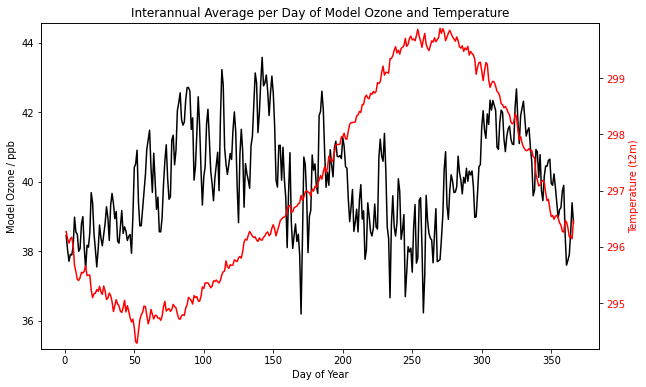

In [11]:
# Convert the 'time' column to datetime format
model_merge['time'] = pd.to_datetime(model_merge['time'])

# Extract day of year from the datetime and create a new column
model_merge['day_of_year'] = model_merge['time'].dt.dayofyear

# Group by day of year and calculate the mean for each day
daily_mean = model_merge.groupby('day_of_year').mean()

# Plotting the interannual average per day of 'ozone' and 't2m'
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'ozone' on the left y-axis
ax1.plot(daily_mean.index, daily_mean['ozone'], label='Model Ozone', color='k')
ax1.set_xlabel('Day of Year')
ax1.set_ylabel('Model Ozone / ppb', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Set the y-axis limit for 'ozone' to cover the range of data
ax1.set_ylim(bottom=daily_mean['ozone'].min() - 1, top=daily_mean['ozone'].max() + 1)

# Create a secondary y-axis for 't2m' on the right side
ax2 = ax1.twinx()

# Plot 't2m' on the secondary y-axis
ax2.plot(daily_mean.index, daily_mean['t2m'], label='Temperature', color='r')
ax2.set_ylabel('Temperature (t2m)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set the y-axis limit for 't2m' to cover the range of data
ax2.set_ylim(bottom=daily_mean['t2m'].min() - 0.1, top=daily_mean['t2m'].max() + 0.1)

# Add title and legend
plt.title('Interannual Average per Day of Model Ozone and Temperature')
plt.show()

Interannual model ozone vs boundary layer height

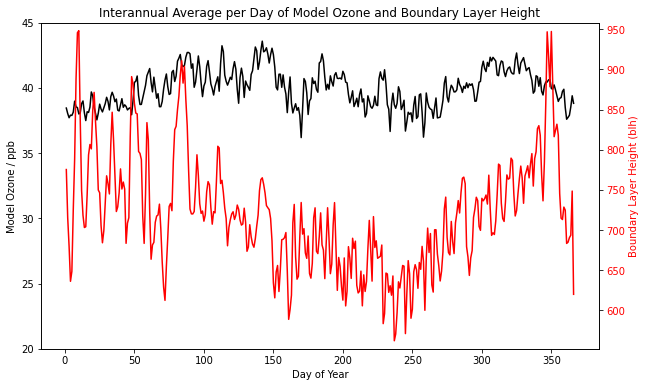

In [12]:
# Convert the 'time' column to datetime format
model_merge['time'] = pd.to_datetime(model_merge['time'])

# Extract day of year from the datetime and create a new column
model_merge['day_of_year'] = model_merge['time'].dt.dayofyear

# Group by day of year and calculate the mean for each day
daily_mean = model_merge.groupby('day_of_year').mean()

# Plotting the interannual average per day of 'ozone' and 'blh'
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'ozone' on the left y-axis
ax1.plot(daily_mean.index, daily_mean['ozone'], label='Model Ozone', color='k')
ax1.set_xlabel('Day of Year')
ax1.set_ylabel('Model Ozone / ppb', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Set the y-axis limit for 'ozone' to cover the range of data
ax1.set_ylim(bottom=20, top=45)

# Create a secondary y-axis for 'blh' on the right side
ax2 = ax1.twinx()

# Plot 'blh' on the secondary y-axis
ax2.plot(daily_mean.index, daily_mean['blh'], label='Boundary Layer Height', color='r')
ax2.set_ylabel('Boundary Layer Height (blh)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set the y-axis limit for 'blh' to cover the range of data
ax2.set_ylim(bottom=daily_mean['blh'].min() - 10, top=daily_mean['blh'].max() + 10)

# Add title and legend
plt.title('Interannual Average per Day of Model Ozone and Boundary Layer Height')
plt.show()

Extract UKESM1 boundary layer height

In [13]:
# Specify the directory containing the files
directory_path = '/scratch/ajp255/homes/mrr32/home/data/PartIII_23/Model_Output/BLH'

# List all files in the directory
file_names = os.listdir(directory_path)

# Create a Pandas DataFrame from the file names
df = pd.DataFrame({'file_name': file_names})

# Extract information from file names
df['base_date'] = df['file_name'].str.extract(r'(\d{8})')

# Convert 'base_date' to datetime format
df['base_date'] = pd.to_datetime(df['base_date'], format='%Y%m%d')
df = df.sort_values(by='base_date', ascending=True)

def process_netcdf_file(file_info, directory_path):
    name, base_date = file_info
    file_path = os.path.join(directory_path, name)

    with Dataset(file_path, 'r') as nc_file:
        data = {}  # Create an empty dictionary to store variable data

        # Define the variables you want and add them to the dictionary
        variable_list = ['time', 'latitude', 'longitude', 'm01s00i025']

        for variable in variable_list:
            if variable in nc_file.variables:
                if variable == 'm01s00i025':
                    data['blh'] = nc_file.variables[variable][:]
                else:
                    data[variable] = nc_file.variables[variable][:]

        # Ensure all arrays have the same length
        min_length = min(len(data[var]) for var in data)
        for var in data:
            data[var] = data[var][:min_length]
        
        # Create a new column 'altitude' and assign a value of 45 for every row
        #data['altitude'] = 300

    # Create a DataFrame for the current file
    return pd.DataFrame(data)

# Create an empty list to store individual DataFrames
dataframes = []

for name, base_date in zip(df['file_name'], df['base_date']):
    result = process_netcdf_file((name, base_date), directory_path)
    if result is not None:
        dataframes.append(result)

# Concatenate all individual DataFrames into a single DataFrame
mod_blh = pd.concat(dataframes, ignore_index=True)
mod_blh = mod_blh.dropna()
mod_blh['time'] = pd.to_datetime(mod_blh['time'], origin='1900-01-01', unit='D')
mod_blh = mod_blh.groupby(pd.Grouper(key='time', freq='h')).mean()

blh_merge = pd.merge(hourly_mod_cvao, mod_blh, on='time', how='inner')
blh_merge = blh_merge.drop_duplicates(subset=['time'])

blh_merge

,time,latitude_x,longitude_x,ozone,latitude_y,longitude_y,blh
0,2007-01-01 00:00:00,16.8636,-24.867201,35.953057,16.8636,-24.867201,879.705963
1,2007-01-01 01:00:00,16.8636,-24.867201,35.905169,16.8636,-24.867201,857.802901
2,2007-01-01 02:00:00,16.8636,-24.867201,35.825110,16.8636,-24.867201,860.122695
3,2007-01-01 03:00:00,16.8636,-24.867201,35.743713,16.8636,-24.867201,863.361315
4,2007-01-01 04:00:00,16.8636,-24.867201,35.650282,16.8636,-24.867201,865.205634
...,...,...,...,...,...,...,...
135114,2022-05-31 18:00:00,16.8636,-24.867201,30.972404,16.8636,-24.867201,524.580007
135115,2022-05-31 19:00:00,16.8636,-24.867201,31.002891,16.8636,-24.867201,503.407468
135116,2022-05-31 20:00:00,16.8636,-24.867201,31.085784,16.8636,-24.867201,551.172017
135117,2022-05-31 21:00:00,16.8636,-24.867201,31.235856,16.8636,-24.867201,632.619020


Compare UKESM1 and ERA5 boundary layer heights

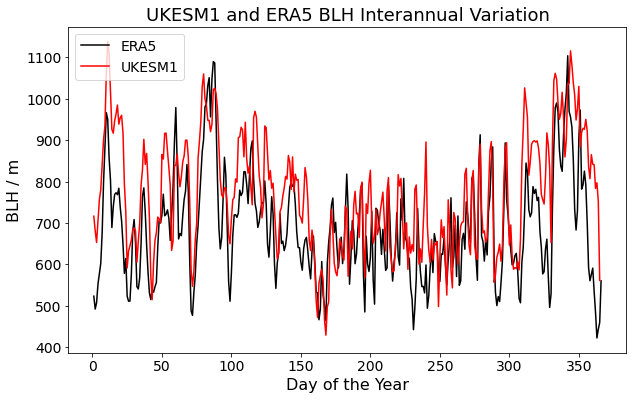

In [16]:
# Convert the 'time' column to datetime format by explicitly creating a copy
blh_merge = blh_merge.copy()
blh_merge['time'] = pd.to_datetime(blh_merge['time'])

# Extract day of the year from the datetime and create a new column
blh_merge['day_of_year'] = blh_merge['time'].dt.dayofyear

# Filter data for years greater than 2018
blh_merge_filtered = blh_merge[blh_merge['time'].dt.year > 2018]

# Group by day of the year and calculate the mean for each day
daily_mod_blh = blh_merge_filtered.groupby('day_of_year').mean()

# Convert the 'time' column to datetime format
model_merge['time'] = pd.to_datetime(model_merge['time'])

# Extract day of year from the datetime and create a new column
model_merge['day_of_year'] = model_merge['time'].dt.dayofyear

# Filter data for years greater than 2018
model_merge_filtered = model_merge[model_merge['time'].dt.year > 2018]

# Group by day of year and calculate the mean for each day
daily_era5_blh = model_merge_filtered.groupby('day_of_year').mean()

# Plotting both ERA5 BLH and model BLH on the same plot
plt.figure(figsize=(10, 6))

# Plot ERA5 BLH
plt.plot(daily_era5_blh.index, daily_era5_blh['blh'], label='ERA5', color='k')

# Plot model BLH
plt.plot(daily_mod_blh.index, daily_mod_blh['blh'], label='UKESM1', color='r')

# Set labels and title
plt.xlabel('Day of the Year', fontsize=16)
plt.ylabel('BLH / m', fontsize=16)
plt.title('UKESM1 and ERA5 BLH Interannual Variation', fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14) 
plt.savefig('/home/ajp255/nethome/Data/TrendPlots/BLH_comparison.png', dpi=600)

# Show plot
plt.show()